#### python import

In [21]:
import os
import pandas as pd
import numpy as np
import lmfit
import glob
import platform
import json
from skimage.filters import median
from skimage.morphology import disk
import copy

from ipywidgets import interactive
from IPython.core.display import HTML
from IPython.display import display

import ipywidgets as widgets

import pprint

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib notebook

## Images size 

In [2]:
image_width = 9576
image_height = 6388
print(f"{image_height/2 =}")
print(f"number of pixels: {image_width * image_height:_}")
print(f"original image is 122MB")

image_height/2 =3194.0
number of pixels: 61_171_488
original image is 122MB


### theoretical center position 

In [3]:
theoretical_center_x_px = 4869
theoretical_center_y_px = 3216

### Pixel size 

this has been calculated by the notebook [calculation of pixel size](calculation_of_pixel_size.ipynb)

In [4]:
pixel_size = 51.010e-3  # mm   

### beam size 

In [5]:
beam_diameter_mm = 22.2157e1 # mm
beam_diameter_px = np.round(beam_diameter_mm / pixel_size)
print(f"{beam_diameter_px = }")
beam_radius_px = beam_diameter_px / 2
beam_radius_mm = beam_diameter_mm / 2

beam_diameter_px = 4355.0


# User input 

Define the **base folder (base_folder)** from where all the data set will be located. 

For example, if you are working on the analysis machine:

*top_folder* = "/SNS/VENUS/IPTS-31716/shared/2023-06-12-analysis/"


In [6]:
if platform.node() == "mac113775":
    top_folder = "/Volumes/JeanHardDrive/SNS/VENUS/IPTS-31716/2023-06-12-analysis/"
elif platform.system() == "Linux":
    top_folder = "/SNS/VENUS/IPTS-31716/shared/2023-06-12-analysis"    
else:
    top_folder = "/Users/j35/SNS/VENUS/IPTS-31716-first_experiment_ever"

### set up base folder 

In [7]:
base_folder = top_folder + "/profiles/beam_center_for_all_apertures"
assert os.path.exists(base_folder)  # making sure the base folder exists

# Loading the data

In [8]:
base_folder = top_folder + "/median_data/"
list_images_to_load = glob.glob(os.path.join(base_folder, "*.tif*"))
list_images_to_load.sort()
assert len(list_images_to_load)>0

In [9]:
progress_bar = widgets.IntProgress()
progress_bar.max = len(list_images_to_load)
display(progress_bar)

images = {}
for _image_filename in list_images_to_load:
    _key = os.path.basename(_image_filename)
    image = np.asarray(Image.open(_image_filename))
    images[_key] = image
    progress_bar.value += 1
    
progress_bar.close()
print("All images have been loaded!")

IntProgress(value=0, max=21)

All images have been loaded!


# Load center position of each aperture 

those data have been produced in the notebook **beam_shape_display_around_beam_center_and_over_image**

In [10]:
with open(os.path.join(top_folder, "all_apertures_beam_center.json"), 'r') as infile:
    mean_centers = json.load(infile)

In [11]:
mean_centers

{'0deg': {'x': 4780.0, 'y': 2955.0},
 '120deg': {'x': 4656.0, 'y': 2682.0},
 '180deg': {'x': 4612.0, 'y': 2654.0},
 '240deg': {'x': 4552.0, 'y': 2639.0},
 '300deg': {'x': 4593.0, 'y': 2726.0},
 '60deg': {'x': 4705.0, 'y': 2808.0}}

In [77]:
l_over_d = {'0deg': 500,
            '120deg': 1200,
            '180deg': 1600,
            '240deg': 2000,
            '300deg': 400,
            '60deg': 800}

### calculate the intensity value at the exp and theo. center positions

In [12]:
def filename_starts_with(filename):
    split_filename = filename.split("_")
    return split_filename[0]

In [13]:
list_json_keys = mean_centers.keys()

for file in images.keys():
    
    key = filename_starts_with(file) 
    if key in list_json_keys:
        
        x = int(mean_centers[key]['x'])
        y = int(mean_centers[key]['y'])
        
        median_pixel_value = np.median([images[file][y, x],
                                        images[file][y-1,x-1],
                                        images[file][y-1,x],
                                        images[file][y-1,x+1],
                                        images[file][y,x+1],
                                        images[file][y+1,x+1],
                                        images[file][y+1,x],
                                        images[file][y+1,x-1],
                                        images[file][y,x-1]])
        
        if mean_centers[key].get('intensity', None):
            mean_centers[key]['intensity'].append(median_pixel_value)
        else:
            mean_centers[key]['intensity'] = [median_pixel_value]
    
for key in list_json_keys:
    mean_centers[key]['average_intensity'] = np.mean(mean_centers[key]['intensity'])
    
    
mean_theoretical_centers = {}
for key in mean_centers.keys():
    mean_theoretical_centers[key] = {'x': theoretical_center_x_px,
                                    'y': theoretical_center_y_px}
  
for file in images.keys():
    
    key = filename_starts_with(file) 
    if key in list_json_keys:
        
        x = theoretical_center_x_px
        y = theoretical_center_y_px
        
        median_pixel_value = np.median([images[file][y, x],
                                images[file][y-1,x-1],
                                images[file][y-1,x],
                                images[file][y-1,x+1],
                                images[file][y,x+1],
                                images[file][y+1,x+1],
                                images[file][y+1,x],
                                images[file][y+1,x-1],
                                images[file][y,x-1]])

            
        if mean_theoretical_centers[key].get('intensity', None):
            mean_theoretical_centers[key]['intensity'].append(median_pixel_value)
        else:
            mean_theoretical_centers[key]['intensity'] = [median_pixel_value]
    
for key in list_json_keys:
    mean_theoretical_centers[key]['average_intensity'] = np.mean(mean_theoretical_centers[key]['intensity'])

# Calculate the pixel that have a value >= 80% max intensity 

<IPython.core.display.Javascript object>


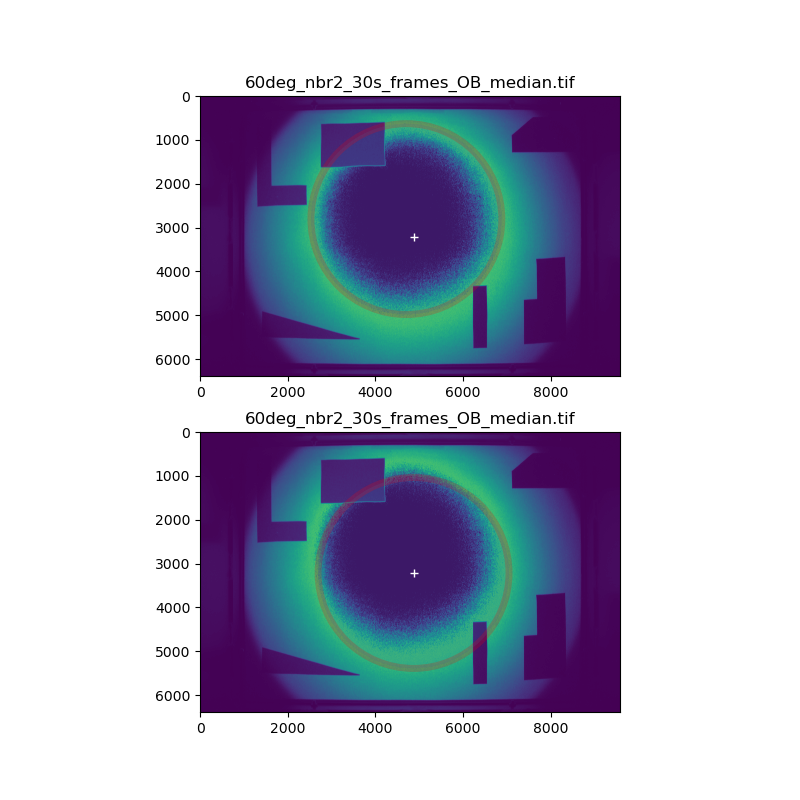

interactive(children=(Dropdown(description='file_name', layout=Layout(width='500px'), options=('0deg_30s_frame…

In [14]:
fig, axis = plt.subplots(num="80% coverage", figsize=(8, 8), nrows=2, ncols=1)

file_name = list(images.keys())[0]
vmin_value = np.min(images[file_name])
vmax_value = np.max(images[file_name])

total_intensity_of_80_coverage_of_experimental_beam_center = 0
def plot(file_name, vmin, vmax):

    # using experimental beam center
    axis[0].cla()
    data = images[file_name]
    axis[0].imshow(data, vmin=vmin, vmax=vmax)
    axis[0].set_title(file_name)
    
    key = filename_starts_with(file_name)
    x_center = mean_centers[key]['x']
    y_center = mean_centers[key]['y']
    axis[0].plot(x, y, 'w+')
    
    beam_center_intensity = mean_centers[key]['average_intensity']
    mask = np.where(data > (beam_center_intensity * 80)/100)
    total_intensity_of_80_coverage_of_experimental_beam_center = np.sum(data[mask])
    
    import copy
    mask_image = copy.deepcopy(data)
    mask_image[mask] = 0
    mask_image[y, x] = beam_center_intensity
    axis[0].imshow(mask_image)
    
    exp_circle = plt.Circle((x_center, y_center), beam_radius_px, 
                            facecolor=None,
                            lw=5,
                            alpha=0.2,
                            edgecolor='red',
                            label='experimental beam')
    axis[0].add_patch(exp_circle)
    
    # using theoretical beam center
    axis[1].cla()
    data = images[file_name]
    axis[1].imshow(data, vmin=vmin, vmax=vmax)
    axis[1].set_title(file_name)
    
    key = filename_starts_with(file_name)
    x_center = mean_theoretical_centers[key]['x']
    y_center = mean_theoretical_centers[key]['y']
    axis[1].plot(x, y, 'w+')
    
    beam_center_intensity = mean_theoretical_centers[key]['average_intensity']
    mask = np.where(data > (beam_center_intensity * 80)/100)
    total_intensity_of_80_coverage_of_theoretical_beam_center = np.sum(data[mask])
    
    import copy
    mask_image = copy.deepcopy(data)
    mask_image[mask] = 0
    mask_image[y, x] = beam_center_intensity
    axis[1].imshow(mask_image)
    
    exp_circle = plt.Circle((x_center, y_center), beam_radius_px, 
                            facecolor=None,
                            lw=5,
                            alpha=0.2,
                            edgecolor='red',
                            label='theoretical beam')
    axis[1].add_patch(exp_circle)
    
    
    theoretical_value = float(total_intensity_of_80_coverage_of_theoretical_beam_center)
    experimental_value = float(total_intensity_of_80_coverage_of_experimental_beam_center)
    file_name_selected = file_name

    num = np.abs(theoretical_value - experimental_value)
    den = experimental_value

    diff = np.divide(num, den)

    direct_diff = experimental_value / theoretical_value
    
    print(f"{file_name_selected}")
    print(f"\t relative difference: {diff * 100: .2f}%")
    print(f"\t direct difference: {direct_diff * 100: .2f}%")

    
display_80_percent = interactive(plot,
                            file_name = widgets.Dropdown(options=images.keys(),
                                                         value=file_name,
                                                        layout=widgets.Layout(width="500px")),
                            vmin = widgets.FloatSlider(min=vmin_value,
                                          max=vmax_value,
                                          value=vmin_value,
                                          continuous_update=False),
                            vmax = widgets.FloatSlider(min=vmin_value,
                                                       max=vmax_value,
                                                       value=vmax_value,
                                                       continuous_update=False),
                           )
display(display_80_percent)

# Automate the full process 

In [71]:
total_intensity_of_80_coverage_of_experimental_beam_center = 0


progress_bar = widgets.IntProgress()
progress_bar.max = len(images.keys())
display(progress_bar)

for file_name in images.keys():
    
    data = images[file_name]
    key = filename_starts_with(file_name)
    if key in ['DF', 'test-DF']:
        continue
    
    x_center = mean_centers[key]['x']
    y_center = mean_centers[key]['y']
    
    beam_center_intensity = mean_centers[key]['average_intensity']
    mask = np.where(data > (beam_center_intensity * 80)/100)

    total_intensity_of_80_coverage_of_experimental_beam_center = np.sum(data[mask])
    
    mask_image = copy.deepcopy(data)
    mask_image[mask] = 0
    mask_image[y, x] = beam_center_intensity
        
    # using theoretical beam center
    
    x_center = mean_theoretical_centers[key]['x']
    y_center = mean_theoretical_centers[key]['y']
    
    beam_center_intensity = mean_theoretical_centers[key]['average_intensity']
    mask = np.where(data > (beam_center_intensity * 80)/100)
    total_intensity_of_80_coverage_of_theoretical_beam_center = np.sum(data[mask])
    
    mask_image = copy.deepcopy(data)
    mask_image[mask] = 0
    mask_image[y, x] = beam_center_intensity
    
    theoretical_value = float(total_intensity_of_80_coverage_of_theoretical_beam_center)
    experimental_value = float(total_intensity_of_80_coverage_of_experimental_beam_center)

    num = np.abs(theoretical_value - experimental_value)
    den = experimental_value

    diff = np.divide(num, den)

    direct_diff = experimental_value / theoretical_value
    
    if mean_centers[key].get('relative_changes', None):
        mean_centers[key]['relative_changes'].append(diff * 100)
        mean_centers[key]['direct_changes'].append(direct_diff * 100)
    else:
        mean_centers[key]['relative_changes'] = [diff * 100]
        mean_centers[key]['direct_changes'] = [direct_diff * 100]
        
    progress_bar.value += 1
    
progress_bar.close()    


# mean of values
for key in mean_centers.keys():
    _relative_mean_value = np.mean(mean_centers[key]['relative_changes'])
    _direct_mean_value = np.mean(mean_centers[key]['direct_changes'])
    
    mean_centers[key]['mean_relative_changes'] = _relative_mean_value
    mean_centers[key]['mean_direct_changes'] = _direct_mean_value


IntProgress(value=0, max=21)

In [78]:
l_over_d_sorted = sorted(l_over_d.items(), key=lambda item:item[1])
l_over_d_sorted

[('300deg', 400),
 ('0deg', 500),
 ('60deg', 800),
 ('120deg', 1200),
 ('180deg', 1600),
 ('240deg', 2000)]

In [79]:
_html = "<table>"
_html += "<tr><th>Aperture Angle</th><th>L/D</th><th>Relative changes(%)</th><th>Direct changes (%)</th></tr>"
for _key, l_over_d in l_over_d_sorted:
    _html += "<tr>"
    _html += f"<td>{_key}" + f"</td><td>{l_over_d}" + f"</td><td>{mean_centers[_key]['mean_relative_changes']:.2f}" + f"</td><td>{mean_centers[_key]['mean_direct_changes']:.2f}</td>"
    _html += "</tr>"
_html += "</table"

display(HTML(_html))

Aperture Angle,L/D,Relative changes(%),Direct changes (%)
300deg,400,6.73,93.69
0deg,500,4.09,104.27
60deg,800,4.73,95.48
120deg,1200,8.50,92.17
180deg,1600,9.30,110.26
240deg,2000,7.33,107.92
